In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import os
import glob
import gc
import functools
from multiprocessing import cpu_count,Pool
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
from sklearn.model_selection import GroupKFold
from sklearn.ensemble import RandomForestRegressor
from FaronF1 import F1Optimizer

pd.options.display.max_columns=200
pd.options.display.max_rows=200


In [2]:
ROOT_DIR = '../data/instacart/files/'
print('loading orders')
# orders = pd.read_csv(ROOT_DIR+'orders.csv', dtype={
#     'order_id':np.int32,
#     'user_id':np.int32,
#     'eval_set':'category',
#     'order_number':np.int16,
#     'order_dow':np.int8,
#     'order_hour_of_day':np.int8,
#     'days_since_prior_order':np.float32
# })

loading orders


#### Features to use

In [3]:
prod_feats = ['product_orders','product_reorders', 'product_reorder_rate', 'product_avg_dow', 'product_avg_hour', 'product_avg_add_to_cart_order',
              'product_avg_days_since_prior_order','aisle_id','department_id', 'product_popularity', 'product_total_basket_items','product_avg_basket_size','product_basket_reorders', 'product_basket_reorder_rate','product_orders_recent',
              'product_reorders_recent', 'product_reorder_rate_recent', 'product_popularity_recent', 'product_avg_time_since_last',
              'product_std_time_since_last', 'product_avg_orders_since_last', 'product_std_orders_since_last','product_avg_time_since_last_recent',
              'product_std_time_since_last_recent', 'product_avg_orders_since_last_recent', 'product_std_orders_since_last_recent']

aisle_feats = ['aisle_orders', 'aisle_reorders', 'aisle_reorder_rate', 'aisle_avg_dow', 'aisle_avg_hour', 'aisle_avg_add_to_cart_order', 'aisle_avg_days_since_prior_order',
               'aisle_popularity', 'aisle_orders_recent', 'aisle_reorders_recent', 'aisle_reorder_rate_recent','aisle_avg_dow_recent',
               'aisle_avg_hour_recent', 'aisle_avg_add_to_cart_order_recent', 'aisle_avg_days_since_prior_order_recent', 
               'aisle_popularity_recent']

user_feats = ['user_total_items', 'user_total_distinct_items', 'user_reorder_rate', 'user_avg_product_diversity','user_reorders', 'user_average_order_dow',
              'user_average_days_between_orders', 'user_std_days_between_orders', 'user_average_basket_size', 'user_avg_reorder_size','user_basket_size_in_last0_order',
              'user_days_since_prior_order_lag0', 'user_order_dow_lag0', 'user_hour_of_day_lag0', 'user_reordered_lag0',  'user_basket_size_in_last1_order',
              'user_days_since_prior_order_lag1', 'user_order_dow_lag1', 'user_hour_of_day_lag1', 'user_reordered_lag1', 'unique_aisles', 'unique_departments', 'nb_none_orders', 'user_total_items_recent',
              'user_total_distinct_items_recent', 'user_reorder_rate_recent', 'user_reorders_recent',
              'user_average_order_dow_recent', 'user_average_days_between_orders_recent', 'user_std_days_between_orders_recent',
              'user_average_basket_size_recent', 'user_avg_reorder_size_recent']

user_order_feats = ['order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order','cumulative_time',
                    'days_since_ratio', 'days_since_cumulative_ratio', 'user_order_velocity', 'days_since_prior_lag0_ratio',
                    'days_since_prior_lag1_ratio']

order_dow_hour_feats = [ 'dow_hour_products',  'dow_hour_reorders', 'dow_hour_reorder_rate', 'dow_hour_unique_products', 'dow_hour_orders']

UP_feats = ['UP_avg_pos_in_cart', 'UP_avg_order_dow', 'UP_first_order', 'UP_orders',
            'UP_std_pos_in_cart', 'UP_total_basket_items', 'UP_avg_basket_size', 'UP_basket_reorders', 'UP_basket_reorder_rate',
            'UP_last_order_number', 'UP_orders_ratio', 'UP_orders_since_last','UP_orders_since_first', 'UP_time_since_last_order',
            'UP_time_since_first_order', 'UP_order_velocity', 'UP_avg_lifespan', 'UP_delta_hour_vs_last', 'UP_delta_dow_vs_last', 'UP_reorder_rate',
            'UP_avg_pos_in_cart_recent','UP_avg_order_dow_recent','UP_orders_recent', 'UP_std_pos_in_cart_recent', 'UP_total_basket_items_recent', 
            'UP_avg_basket_size_recent', 'UP_basket_reorders_recent', 'UP_basket_reorder_rate_recent', 'UP_reorder_rate_recent','UP_lifespan_vs_time_since_last', 'UP_user_share',
            'UP_avg_time_since_last', 'UP_std_time_since_last', 'UP_avg_time_since_last_recent', 'UP_std_time_since_last_recent', 'UP_avg_time_since_last_vs_UP_time_since_last',
            'UP_avg_time_since_last_recent_vs_UP_time_since_last', 'UP_avg_orders_since_last', 'UP_std_orders_since_last', 
            'UP_avg_time_since_last_recent', 'UP_std_time_since_last_recent', 'UP_avg_orders_since_last_vs_UP_orders_since_last',
            'UP_avg_orders_since_last_recent_vs_UP_orders_since_last']


UA_feats = ['UA_avg_pos_in_cart', 'UA_orders', 'UA_first_order', 'UA_avg_order_dow', 'UA_last_order_number',
           'UA_orders_ratio', 'UA_orders_since_last', 'UA_orders_since_first', 'UA_time_since_last_order', 'UA_time_since_first_order',
           'UA_order_velocity', 'UA_avg_lifespan', 'UA_reorder_rate']
new_UA_feats = ['UA_unique_prod_per_aisle', 'UA_prod_rank_by_reorder_rate', 'UA_prod_rank_by_reorder_rate_recent', 'UA_prod_rank_by_orders', 'UA_prod_share_within_aisle']

prod_dow_feats = ['product_dow_orders', 'product_dow_reorders', 'product_dow_reorder_rate', 'product_dow_popularity']
user_dow_feats = ['user_dow_products', 'user_dow_reorders', 'user_dow_reorder_rate']
user_days_since_feat = ['user_days_since_total_prods', 'user_days_since_orders', 'user_days_since_reordered', 
                       'user_days_since_reorder_rate', 'user_days_since_avg_basket']

In [4]:
file_dict=dict()
files = glob.glob(ROOT_DIR+'cleaned_train/*.csv')
# for f in files[]:
#     file_dict[f.split('/')[-1][:-4]] = pd.read_csv(f)
#     file_dict[f.split('/')[-1][:-4]]['predicted'] = 0
file_dict['valid_onr_0'] = pd.read_csv(ROOT_DIR+'cleaned_train/valid_onr_0.csv',usecols=['user_id', 'product_id', 'reordered', 'order_id', 'user_aisle']+prod_feats+UP_feats+user_order_feats+user_feats+UA_feats)
file_dict['valid_onr_0'].loc[file_dict['valid_onr_0'].product_avg_days_since_prior_order.isnull(),'product_avg_days_since_prior_order' ] = -99

In [5]:
for col in file_dict['valid_onr_0'].columns:
    if file_dict['valid_onr_0'][col].dtype == 'int64':
        file_dict['valid_onr_0'][col] = file_dict['valid_onr_0'][col].astype(np.int32)
    elif file_dict['valid_onr_0'][col].dtype == 'float64':
        file_dict['valid_onr_0'][col] = file_dict['valid_onr_0'][col].astype(np.float32)
    else:
        continue

In [ ]:
test =pd.read_csv(ROOT_DIR + 'cleaned_test/test.csv', usecols=['user_id', 'product_id', 'order_id']+prod_feats+user_order_feats+UP_feats+user_feats+UA_feats+new_UA_feats)

In [8]:
for col in test.columns:
    if test[col].dtype == 'int64':
        test[col] = test[col].astype(np.int32)
    elif test[col].dtype == 'float64':
        test[col] = test[col].astype(np.float32)
    else:
        continue

#### making folds based on users

In [6]:
SEED = 2017
np.random.seed(SEED)
users = pd.DataFrame(file_dict['valid_onr_0'].user_id.unique(), columns=['user_id'])
# creating 3-folds for time being
users['fold'] = np.random.permutation(users.shape[0])%5
file_dict['valid_onr_0'] = pd.merge(file_dict['valid_onr_0'], users, on='user_id')
del users
for i in range(3):gc.collect()

In [7]:
file_dict['valid_onr_0']['fold'] = file_dict['valid_onr_0']['fold'].astype(np.int16)

In [8]:
for i in range(3):gc.collect()

In [9]:
file_dict['valid_onr_0']['predicted'] = 0

In [10]:
file_dict['valid_onr_0']['predicted'] = file_dict['valid_onr_0']['predicted'].astype(np.float32)

#### lightgbm params

In [11]:


params = {
    'task':'train',
    'boosting_type':'gbdt',
    'objective':'binary',
    'metric':{'binary_logloss','auc'},
    'num_leaves':90,
    'max_depth':7,
    'feature_fraction':0.8,
    #'bagging_fraction':0.8,
    'bagging_freq':5,
    'device':'gpu',
    'gpu_use_dp':False,
    'learning_rate':0.05
   # 'verbose':0
}
ROUNDS = 800


# params = {
#     'task': 'train',
#     'boosting_type': 'gbdt',              # Gradient boosting tree algorithm
#     'objective': 'binary',
#     'metric': {'binary_logloss', 'auc'},
#     'num_iterations' : 1000,              
#     'max_bin' : 100,                      # Controls overfit
#     'num_leaves': 512,                    # higher number of leaves
#     'feature_fraction': 0.9,              # Controls overfit
#     'bagging_fraction': 0.95,
#     'bagging_freq': 5,
#     'min_data_in_leaf' : 200,             # Controls overfit
#     'learning_rate' : 0.1,
#     'device' : 'gpu',                     # Disable this if not using GPU
#     'gpu_use_dp' : True,                  # To make GPU use double precision
# }
# ROUNDS = 200




In [8]:
def get_f1score(x, threshold=0.2):
    y_true = np.concatenate([x.loc[x.reordered==1, 'product_id']])
    if len(y_true) == 0:
        y_true = [49689]
    
    y_pred = np.concatenate([x.loc[x.predicted>threshold, 'product_id']])
    if np.sum(y_pred==49689)>0:
        y_pred = [49689]
    if len(y_pred) == 0:
        y_pred = [49689]
    
    precision = sum([1 for i in y_pred if i in y_true]) / float(len(y_pred))
    recall = sum([1 for i in y_true if i in y_pred]) / float(len(y_true))
    if precision + recall == 0:
        return 0
    return (2 * precision * recall) / float((precision + recall))

In [12]:
def get_f1score(x, threshold=0.2):
    y_true = x.loc[x.reordered==1, 'product_id'].values
    if len(y_true) == 0:
        y_true = ['None']
    if x.bask_size.values[0] == 0:
        y_pred = ['None']
    else:
        
        prod_index = x.predicted.values.argsort()[::-1][:int(x.bask_size.values[0])]        
        y_pred = x.product_id.values[prod_index]
    if len(y_pred) == 0:
        y_pred = ['None']
    
    precision = sum([1 for i in y_pred if i in y_true]) / float(len(y_pred))
    recall = sum([1 for i in y_true if i in y_pred]) / float(len(y_true))
    if precision + recall == 0:
        return 0
    return (2 * precision * recall) / float((precision + recall))

In [13]:
def f1_maximization(order_id):
    p_vals = file_dict['valid_onr_0'].loc[file_dict['valid_onr_0'].order_id==order_id, 'predicted'].values
    
    k,is_none,expected_F1 = F1Optimizer.maximize_expectation(p_vals)
    return order_id, k
#

In [14]:
feat_dict = {
    'run_0':UP_feats, #0.38463266746913854
    'run_1':UP_feats+prod_feats, #0.390830065413
    'run_2':UP_feats+prod_feats+user_order_feats,#score0.39258282209
    'run_3':UP_feats+prod_feats+user_order_feats+user_feats,#score0.394517711266
    'run_4':UP_feats+prod_feats+user_order_feats+user_feats+UA_feats,#score0.3952425521
    'run_5':UP_feats+prod_feats+user_order_feats+user_feats+UA_feats+new_UA_feats, #score0.395034661612
    'run_6':UP_feats+prod_feats+user_order_feats+user_feats+UA_feats+prod_dow_feats+user_dow_feats#score0.395034425763
}

[1]	valid_0's binary_logloss: 0.658388	valid_0's auc: 0.821082
Train until valid scores didn't improve in 30 rounds.
[2]	valid_0's binary_logloss: 0.626925	valid_0's auc: 0.824569
[3]	valid_0's binary_logloss: 0.59836	valid_0's auc: 0.825217
[4]	valid_0's binary_logloss: 0.572392	valid_0's auc: 0.826569
[5]	valid_0's binary_logloss: 0.548612	valid_0's auc: 0.827102
[6]	valid_0's binary_logloss: 0.52697	valid_0's auc: 0.82727
[7]	valid_0's binary_logloss: 0.506934	valid_0's auc: 0.827437
[8]	valid_0's binary_logloss: 0.488512	valid_0's auc: 0.827741
[9]	valid_0's binary_logloss: 0.471532	valid_0's auc: 0.82797
[10]	valid_0's binary_logloss: 0.45597	valid_0's auc: 0.828109
[11]	valid_0's binary_logloss: 0.441467	valid_0's auc: 0.828315
[12]	valid_0's binary_logloss: 0.42806	valid_0's auc: 0.82842
[13]	valid_0's binary_logloss: 0.415642	valid_0's auc: 0.828453
[14]	valid_0's binary_logloss: 0.404116	valid_0's auc: 0.828577
[15]	valid_0's binary_logloss: 0.393422	valid_0's auc: 0.828665
[1

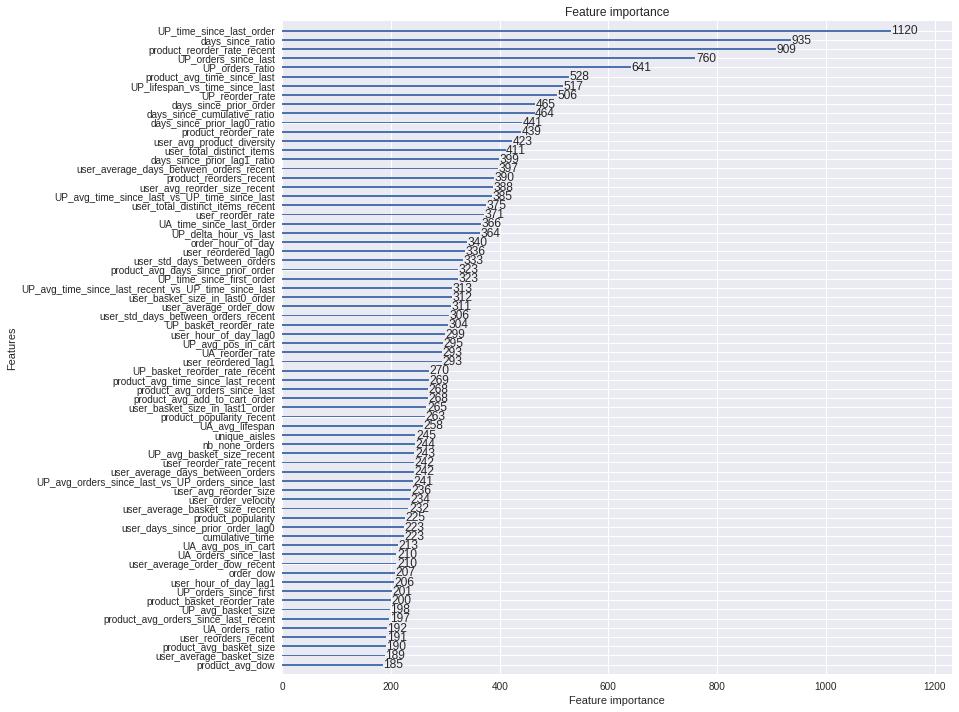

In [15]:
feature_importance = []
order_bask_size = []
for fol in range(1):
    evals_result = {}
    
    lgb_train = lgb.Dataset(file_dict['valid_onr_0'].loc[file_dict['valid_onr_0'].fold!=fol, feat_dict['run_'+str(4)]],
                            file_dict['valid_onr_0'].loc[file_dict['valid_onr_0'].fold!=fol,'reordered'],categorical_feature=['aisle_id', 'department_id'])
    
    lgb_valid = lgb.Dataset(file_dict['valid_onr_0'].loc[file_dict['valid_onr_0'].fold==fol, feat_dict['run_'+str(4)]],
                            file_dict['valid_onr_0'].loc[file_dict['valid_onr_0'].fold==fol,'reordered'], reference=lgb_train,categorical_feature=['aisle_id', 'department_id'])
    
    gbm = lgb.train(params, train_set=lgb_train, valid_sets=lgb_valid, num_boost_round=ROUNDS,
                    evals_result=evals_result, early_stopping_rounds=30)
        
    
    ax = lgb.plot_importance(gbm, max_num_features=70, figsize=(12,12))

    #print('run_{}:f1score-{}'.format(i, t.mean()))
    #del lgb_train
    #if i!=4:
    #del gbm
    for _ in range(3):gc.collect()
# p = Pool(cpu_count())
# order_bask_size = p.map(f1_maximization, list(file_dict['valid_onr_0'][file_dict['valid_onr_0'].fold==fol].order_id.unique()))
# order_ids, bask_size = zip(*order_bask_size)
# basket_df = pd.DataFrame({
#         'order_id':order_ids,
#         'bask_size':bask_size
#     })
    
# file_dict['valid_onr_0'] = pd.merge(file_dict['valid_onr_0'], basket_df, on='order_id', how='left')
# #t = file_dict['valid_onr_0'][file_dict['valid_onr_0'].fold==fol].groupby('order_id').apply(get_f1score)
# #print('score{}'.format(t.mean()))
# #file_dict['valid_onr_0'].drop('bask_size', axis=1, inplace=True)   

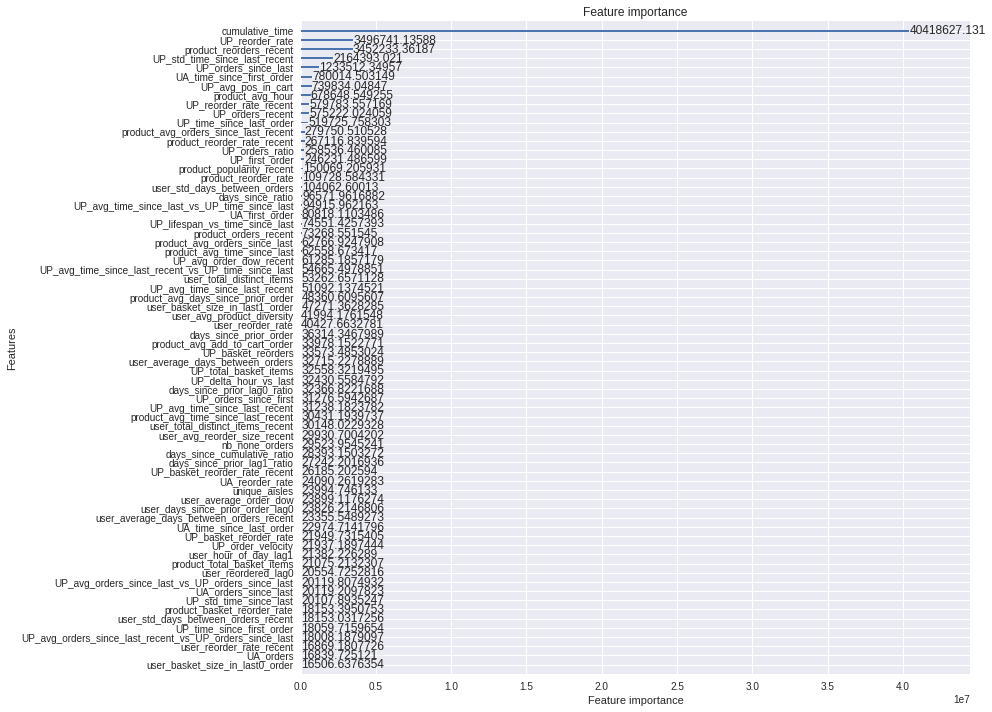

In [16]:
ax = lgb.plot_importance(gbm, max_num_features=70, importance_type='gain', figsize=(12, 12))

In [67]:
len(gbm.feature_importance(importance_type='gain').argsort())
important_features = np.array(gbm.feature_name())[gbm.feature_importance(importance_type='gain').argsort()[::-1][:70]]

In [68]:
important_features

array([u'cumulative_time', u'UP_reorder_rate', u'product_reorders_recent',
       u'UP_std_time_since_last_recent', u'UP_orders_since_last',
       u'UA_time_since_first_order', u'UP_avg_pos_in_cart',
       u'product_avg_hour', u'UP_reorder_rate_recent', u'UP_orders_recent',
       u'UP_time_since_last_order',
       u'product_avg_orders_since_last_recent',
       u'product_reorder_rate_recent', u'UP_orders_ratio',
       u'UP_first_order', u'product_popularity_recent',
       u'product_reorder_rate', u'user_std_days_between_orders',
       u'days_since_ratio',
       u'UP_avg_time_since_last_vs_UP_time_since_last', u'UA_first_order',
       u'UP_lifespan_vs_time_since_last', u'product_orders_recent',
       u'product_avg_orders_since_last', u'product_avg_time_since_last',
       u'UP_avg_order_dow_recent',
       u'UP_avg_time_since_last_recent_vs_UP_time_since_last',
       u'user_total_distinct_items', u'UP_avg_time_since_last_recent',
       u'product_avg_days_since_prior_order',


In [43]:
t = file_dict['valid_onr_0'][file_dict['valid_onr_0'].fold==fol].groupby('order_id').apply(get_f1score)

/home/cvpr/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:15: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/home/cvpr/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:14: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


In [44]:
t.mean()

0.3966754796523777

In [45]:
??lgb.plot_importance

In [41]:
order_bask_size = p.map(f1_maximization, list(file_dict['valid_onr_0'].order_id.unique()))

In [43]:
order_ids, bask_size = zip(*order_bask_size)

In [45]:
basket_df = pd.DataFrame({
        'order_id':order_ids,
        'bask_size':bask_size
    })

In [46]:
file_dict['valid_onr_0'] = pd.merge(file_dict['valid_onr_0'], basket_df, on='order_id', how='left')

In [47]:
t = file_dict['valid_onr_0'].groupby('order_id').apply(get_f1score)

/home/cvpr/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:13: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/home/cvpr/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:14: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


In [48]:
t.mean()

0.38463266746913854

In [17]:
cols_to_write = ['user_id', 'order_id', 'product_id','predicted', 'reordered', 'fold']
file_dict['valid_onr_0'][cols_to_write].to_csv(ROOT_DIR+'out_of_fold_preds.csv', index=False)

#### Training on entire set

In [ ]:
lgb_train = lgb.Dataset(file_dict['valid_onr_0'][feat_dict['run_0']],
                            file_dict['valid_onr_0']['reordered'],categorical_feature=['aisle_id', 'department_id'])
gbm = lgb.train(params,train_set=lgb_train,num_boost_round=ROUNDS)    

In [ ]:
preds = gbm.predict(test[feat_dict['run_0']])
test['preds'] = preds


In [ ]:
cols_to_write = ['user_id', 'order_id', 'product_id','preds']
test[cols_to_write].to_csv(ROOT_DIR+'test_preds.csv', index=False)

In [20]:
np.save(ROOT_DIR + 'preds.npy', preds)

In [35]:
test['preds_cutoff'] = clf.predict(test[var[1:]])

In [13]:
def get_submission(x, threshold=0.2):
    y_pred = ''
    if len(x)<=20:
        threshold=0.001
    else:
        threshold=0.2
    if np.prod(1-x.preds)>threshold:
        y_pred = 'None'
    else:
        y_pred = ' '.join(np.concatenate([x.loc[x.preds>threshold, 'product_id']]).astype(np.str))
    if len(y_pred) == 0:
        y_pred = 'None'
    return y_pred
    

In [14]:
sub_df = test.groupby('order_id').apply(get_submission).reset_index()
sub_df.columns = ['order_id', 'products']
sub_df.to_csv(ROOT_DIR+'none_handled_0.37.csv', index=False)

In [9]:
threshold = 0.2
d = dict()
for row in test.itertuples():
    if row.preds > threshold:
        try:
            d[row.order_id] += ' ' + str(row.product_id)
        except:
            d[row.order_id] = str(row.product_id)

for order in orders[orders.eval_set=='test'].order_id:
    if order not in d:
        d[order] = 'None'

sub = pd.DataFrame.from_dict(d, orient='index')
sub.reset_index(inplace=True)
sub.columns = ['order_id', 'products']
sub.to_csv(ROOT_DIR+'paulantoine_lgb_starter.csv', index=False)

array([ 0.1955    ,  0.22975   ,  0.18495   , ...,  0.18212167,
        0.22755   ,  0.2128    ])

In [39]:
t = t.reset_index()
t.columns = ['user_id', 'f1']
t = pd.merge(t, valid_X[['user_id', 'basket_size_in_last0_order']].drop_duplicates(), on='user_id', how='left')

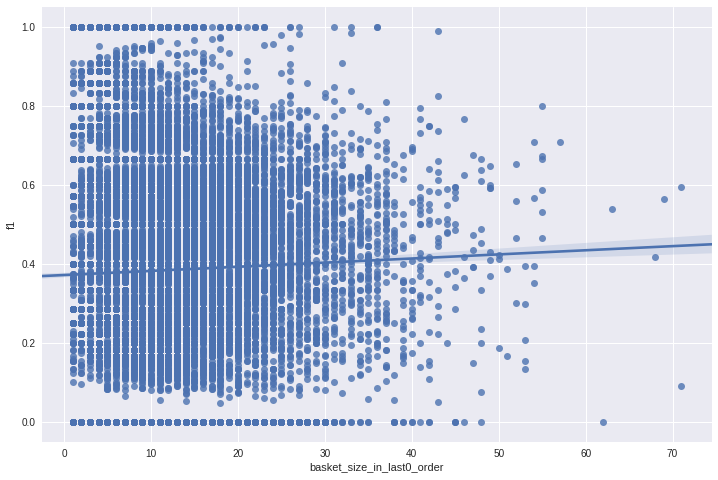

In [40]:
plt.figure(figsize=(12, 8))
sns.regplot(t.basket_size_in_last0_order, t.f1)
plt.show()

SpearmanrResult(correlation=0.032760222207036081, pvalue=1.1075828945496622e-07)